# Тестовое задание

## Описание
Даны результаты предсказания модели детекции головы котов и разметка датасета.
## Задача
Проанализировать результаты и качество предсказания модели (посчитать любые подходящие метрики) и оформить в виде презентации.
## Описание данных
Даны файлы predictions.xlsx - предсказания модели и ground_truth.xlsx - разметка датасета. В папке images представлены изображения, по которым проводилась детекция.

`file` — название файла

`pred_label` — предсказанный класс объекта (0 - нет головы кота, 1 - обнаружена голова кота)

`pred_bbox` — предсказанный бокс объекта (x, y, ширина, высота - координаты центра и размер относительно ширины и высоты изображения)

`truth_label` — истинный класс объекта

`truth_bbox` — истинный бокс объекта

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from shapely.geometry import Polygon

plt.style.use('dark_background')

In [2]:
""" Загрузка данных """
predictions = pd.read_excel(r'D:\Учеба\Data Scientist\Проекты\Тестовое NVI\predictions.xlsx')
ground_truth = pd.read_excel(r'D:\Учеба\Data Scientist\Проекты\Тестовое NVI\ground_truth.xlsx')

In [3]:
predictions.head()

,file,pred_label,pred_bbox
0,Image_AY1ZWZD5.jpg,0,NaN
1,Image_B2Z6BH7R.jpg,0,NaN
2,Image_YTXYC9BS.jpg,1,"[0.56886, 0.476772, 0.35424, 0.580991]"
3,Image_DBX2S91J.jpg,1,"[0.63865, 0.198551, 0.4647, 0.298822]"
4,Image_CPZW8OAO.jpg,1,"[0.47552, 0.422169, 0.4088, 0.594699]"


Объединим данные с предсказаниями и истинными значениями в один датафрейм

In [4]:
full = predictions.set_index('file').join(ground_truth.set_index('file'))

In [5]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Image_AY1ZWZD5.jpg to Image_WMD6T1QA.jpg
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pred_label   50 non-null     int64 
 1   pred_bbox    35 non-null     object
 2   truth_label  50 non-null     int64 
 3   truth_bbox   28 non-null     object
dtypes: int64(2), object(2)
memory usage: 4.0+ KB


In [6]:
full.describe()

,pred_label,truth_label
count,50.00000,50.000000
mean,0.70000,0.560000
std,0.46291,0.501427
min,0.00000,0.000000
25%,0.00000,0.000000
50%,1.00000,1.000000
75%,1.00000,1.000000
max,1.00000,1.000000


Видно, что модель чаще предсказывает наличие объекта на изображении, чем он, в действительности, там есть.

## Расчет метрик

In [7]:
accuracy = accuracy_score(full.truth_label, full.pred_label)
print(f'Значение метрики accuracy: {accuracy:.2f}')

Значение метрики accuracy: 0.86


In [8]:
precision = precision_score(full.truth_label, full.pred_label)
print(f'Значение метрики precision: {precision:.2f}')

Значение метрики precision: 0.80


In [9]:
recall = recall_score(full.truth_label, full.pred_label)
print(f'Значение метрики recall: {recall:.2f}')

Значение метрики recall: 1.00


In [10]:
f1 = f1_score(full.truth_label, full.pred_label)
print(f'Значение метрики f1: {f1:.2f}')

Значение метрики f1: 0.89


Посчитаем матрицу ошибок

In [11]:
cm = confusion_matrix(full.truth_label, full.pred_label)
cm

array([[15,  7],
       [ 0, 28]], dtype=int64)

Напишем функцию для определения метрики IoU и вспомогательную функцию построения прямоугольников для боксов по координатам и размерам

In [12]:
def rectangle(x, y, w, h):
    rect = Polygon(((x - w / 2, y - h / 2), (x - w / 2, y + h / 2), 
            (x + w / 2, y + h / 2), (x + w / 2, y - h / 2)))
    return rect

def iou_score(row):
    truth = [float(i.strip()) for i in row.truth_bbox[1: -1].split(',')]
    truth_rect = rectangle(*truth)
    
    pred = [float(i.strip()) for i in row.pred_bbox[1: -1].split(',')]
    pred_rect = rectangle(*pred)
    
    iou = truth_rect.intersection(pred_rect).area / truth_rect.union(pred_rect).area
    return iou

Создадим вспомогательную таблицу с истинно-положительными значениями в датасете

In [13]:
tp = full[(full.pred_label == 1) & (full.truth_label == 1)]
tp.head()

,pred_label,pred_bbox,truth_label,truth_bbox
file,,,,
Image_DBX2S91J.jpg,1,"[0.63865, 0.198551, 0.4647, 0.298822]",1,"[0.678, 0.20457, 0.4364, 0.24793]"
Image_CPZW8OAO.jpg,1,"[0.47552, 0.422169, 0.4088, 0.594699]",1,"[0.48533, 0.426627, 0.45522, 0.64988]"
Image_CVRESW2M.jpg,1,"[0.581975, 0.19309, 0.2755, 0.269598]",1,"[0.586462, 0.200226, 0.300875, 0.298643]"
Image_ACCFVSLA.jpg,1,"[0.372436, 0.469481, 0.201818, 0.309672]",1,"[0.665982, 0.322377, 0.203745, 0.356885]"
Image_HSGPZGBX.jpg,1,"[0.55142, 0.439925, 0.26788, 0.406175]",1,"[0.55205, 0.436973, 0.30182, 0.441416]"


Добавим дополнительный столбец с рассчетом метрики IoU

In [14]:
tp['iou'] = tp.apply(iou_score, axis=1)

E:\Anaconda\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\epoxa\AppData\Local\Temp\ipykernel_260\2604550691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp['iou'] = tp.apply(iou_score, axis=1)


In [15]:
iou_mean = tp['iou'].mean()
print(f'Среднее значение метрики IoU: {iou_mean:.2f}')

Среднее значение метрики IoU: 0.58


Посчитаем долю объектов, у которых перекрытие боксов составляет менее 50%

In [17]:
mismatch = len(tp[tp.iou < 0.5]) / len(tp)
print(f'Доля неверно расположенных боксов: {mismatch:.2f}')

Доля неверно расположенных боксов: 0.29


## Заключение

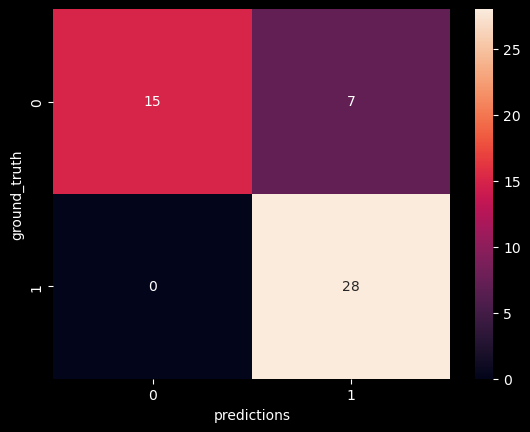

In [23]:
sns.heatmap(cm, annot=True)
plt.xlabel('predictions')
plt.ylabel('ground_truth')
plt.show()

Доля правильно класиифицированных изображений (метрика Accuracy) составляет 0.86. Доля правильно предсказанных положительных объектов (метрика Precision) составляет 0.8. Модель отметила все изображения, имеющие положительные метки, как положительные (метрика Recall равна 1). Несмотря на верную классификацию всех положительных объектов, у порядка 29% из них модель отметила неправильную область изображения с объектом. В среднем же степень перекрытия между предсказанным боксом и истинным боксом (метрика IoU) составляет 0.58